In [1]:
import sys
import time
import pprint
import datetime
import tweet_query
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tweet_query.counters import logging_init
logging_init()

# Counter Object Initialization

The main feature of this package is the python Counters object, which stores 
* n-gram counts, 
* date indexes,
* subsample resolution,
* other metadata,

provides methods for common data operations
* loading from remote databases, 
* caching,
* aggregation, 
* converting to pandas, etc.

and provides endpoints for common plotting functionality
* ambient timeseries
* sentiment timeseries
* sentiment shifts

In [5]:
start_date = datetime.datetime(2019, 9, 1)
end_date = datetime.datetime(2021, 8, 31)
freq = 'D'
dates = pd.date_range(start_date, end_date, freq=freq)
high_res = True

anchor = 'Vaccine'

counters = tweet_query.counters.Counters(dates,
                                         anchor,
                                         high_res=high_res,
                                         )

In [6]:
# printing provides quick access to metadata
print(counters)

Counters object: 
    Anchor - Vaccine 
    Dates - 2019-09-01 00:00:00+00:00 to 2021-08-31 00:00:00+00:00
    Scheme - 1grams
    Lang - en
    Save Path - /home/michael/tweet_query/tweet_query/../data/ambient/vaccine_2019-09-01_2021-08-31_ten_percent-True_freq_<Day>.json


In [7]:
counters.get(save=True, json=False)

Querying Vaccine from tweet db...
Returned Vaccine from tweet db in 1741.32s


Inserting counters for first time.


# Ambient Timeseries

Often, we want to know how much a given word or words is being used inside of subset of tweets.

For a single timeseries, we can use `counters.to_series()` to return a Pandas timeseries.

For a group of the top $N$ timeseries, we can use `counters.to_timeseries_dataframe()`

Both methods take an argument `count_type,` which allows you choose from `{'freq', 'freq_no_rt', 'count', 'count_no_rt'}.`

In [8]:
# export a single ambient timeseries to a pandas series
counters.to_series(word='the', count_type='freq')

2019-09-01 00:00:00+00:00    0.029536
2019-09-02 00:00:00+00:00    0.030148
2019-09-03 00:00:00+00:00    0.029325
2019-09-04 00:00:00+00:00    0.034423
2019-09-05 00:00:00+00:00    0.032292
                               ...   
2021-08-26 00:00:00+00:00    0.035917
2021-08-27 00:00:00+00:00    0.031019
2021-08-28 00:00:00+00:00    0.031456
2021-08-29 00:00:00+00:00    0.000000
2021-08-30 00:00:00+00:00    0.000000
Name: the, Length: 730, dtype: float64

# Ambient Timeseries Plot
A quick method to plot the frequency of ambient words. 

Plots missing days as dots along the bottom to give a sense of missing data.

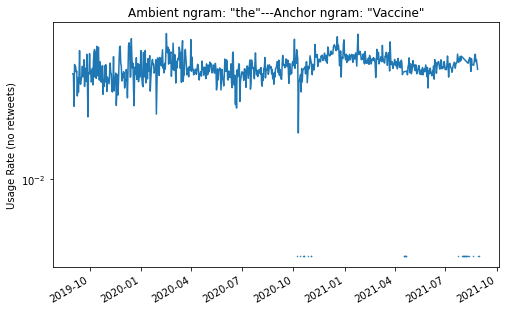

<AxesSubplot:title={'center':'Ambient ngram: "the"---Anchor ngram: "Vaccine"'}, ylabel='Usage Rate (no retweets)'>

In [9]:
# export the top N ambient timeseries to a pandas dataframe
# change to 'freq_no_rt'
counters.plot_ambient_timeseries('the', count_type='freq_no_rt')

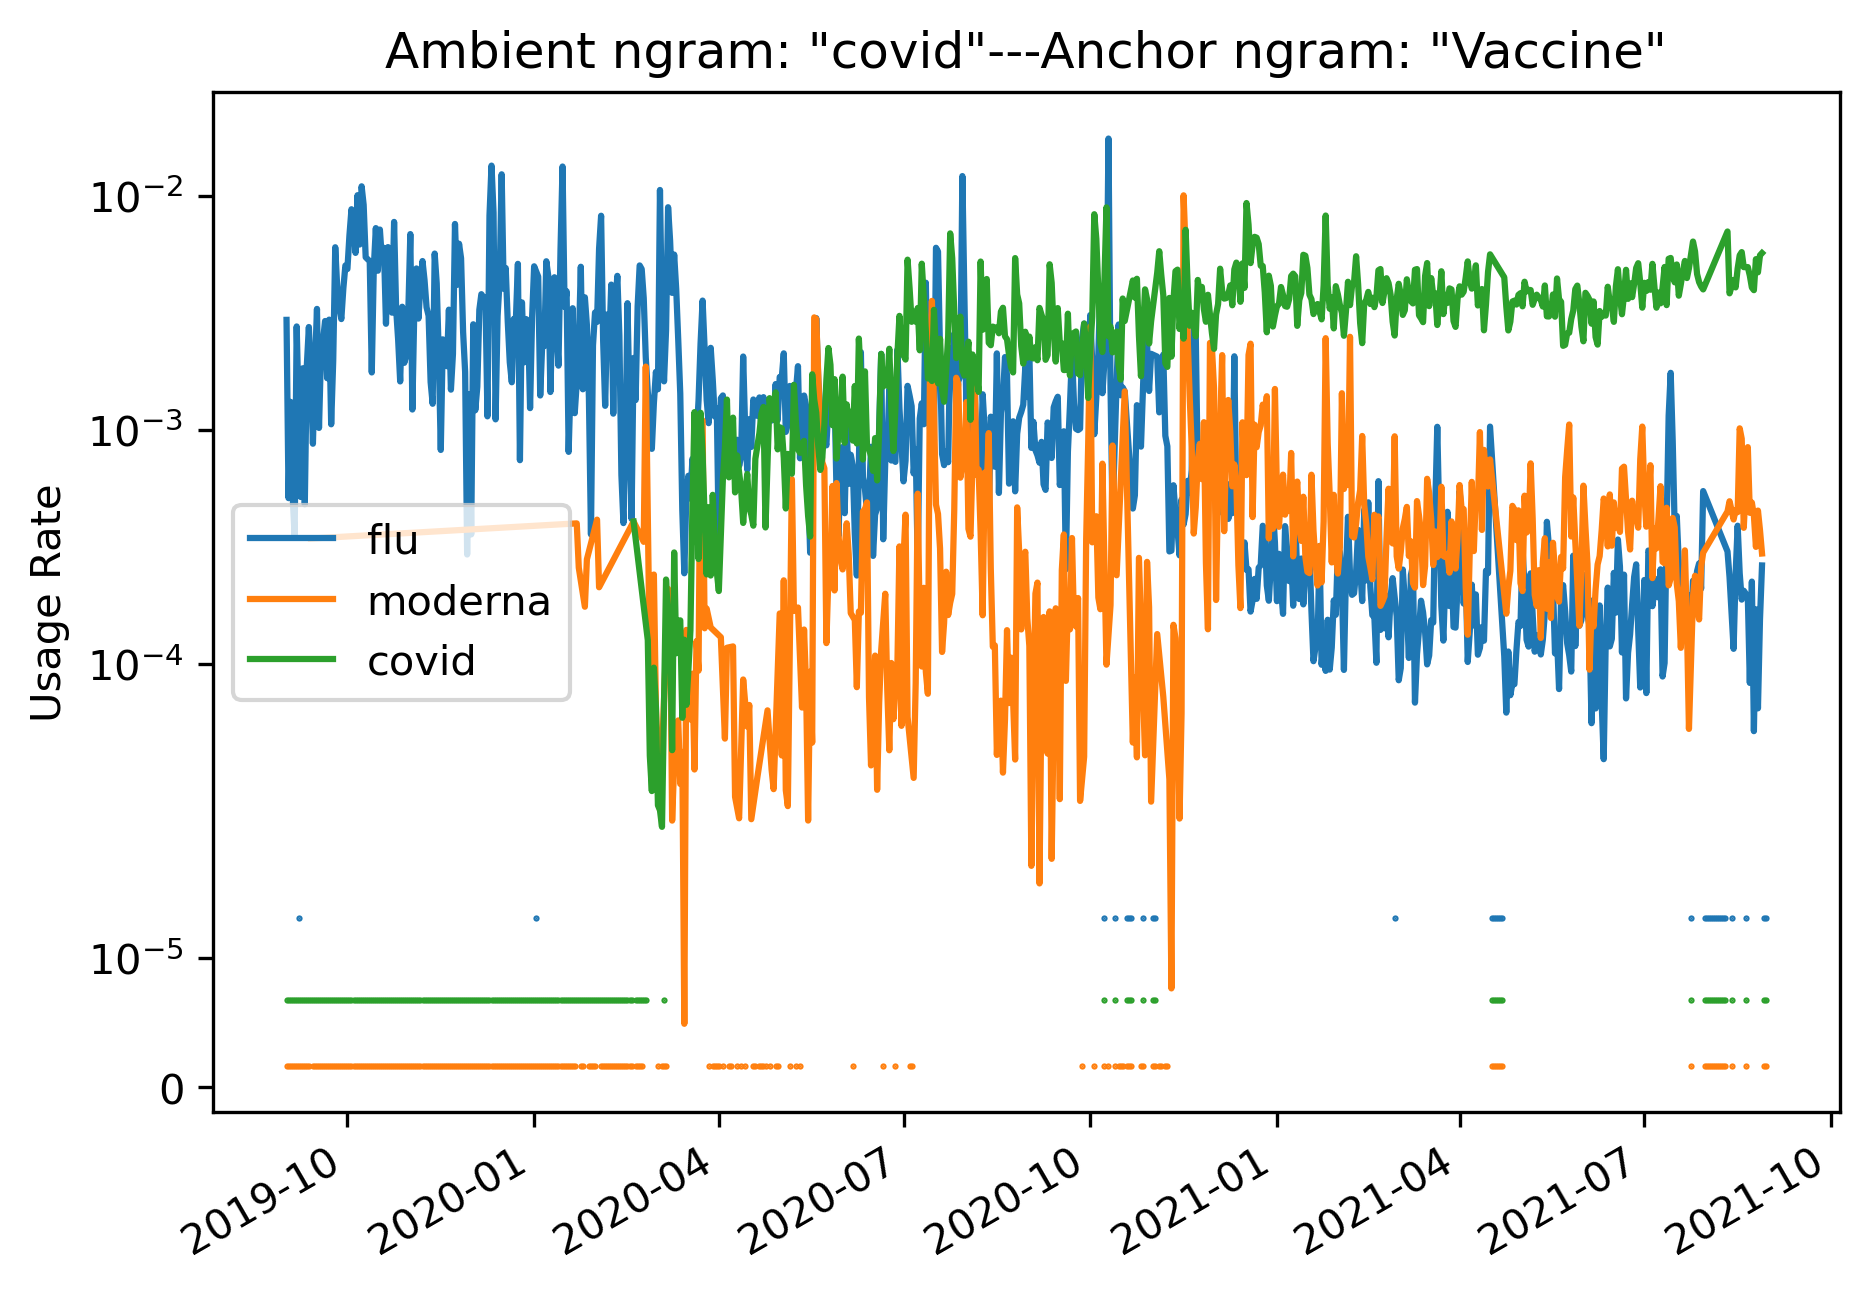

In [10]:
f, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=300)
counters.plot_ambient_timeseries('flu', ax=ax)
counters.plot_ambient_timeseries('moderna', ax=ax)
counters.plot_ambient_timeseries('covid', ax=ax)

plt.legend();

# Aggregation

While ambient n-gram counts are stored at the day level, we often want to aggregate to the week, month, or year.

A class method makes this easy. Just specify the freqency string, as you would for a pandas date_range, e.g. `{'D', '2D', 'W', 'M', 'Y'}.`



In [11]:
counters.aggregate('2W')

# Ambient Sentiment

Getting ambient sentiment data is easy with `counters.happs_series().` Specify the anchor word you used and the count type you'd like to score. 

Returns 3 Pandas DataFrames, `(df_sentiment, df_count, df_SDOM).`

Plotting is handled by the `counters.plot_sentiment_timeseries()` method, which shows:
* the total number of ngrams being used to score at each time step,
* plots ambient sentiment as a step function,
* and represents uncertainty in the sentiment timeseries as the standard deviation of the mean of each time step. 

In $\sigma/\sqrt{n}$, $n$ is the number of tweets.

Plotting: Vaccine


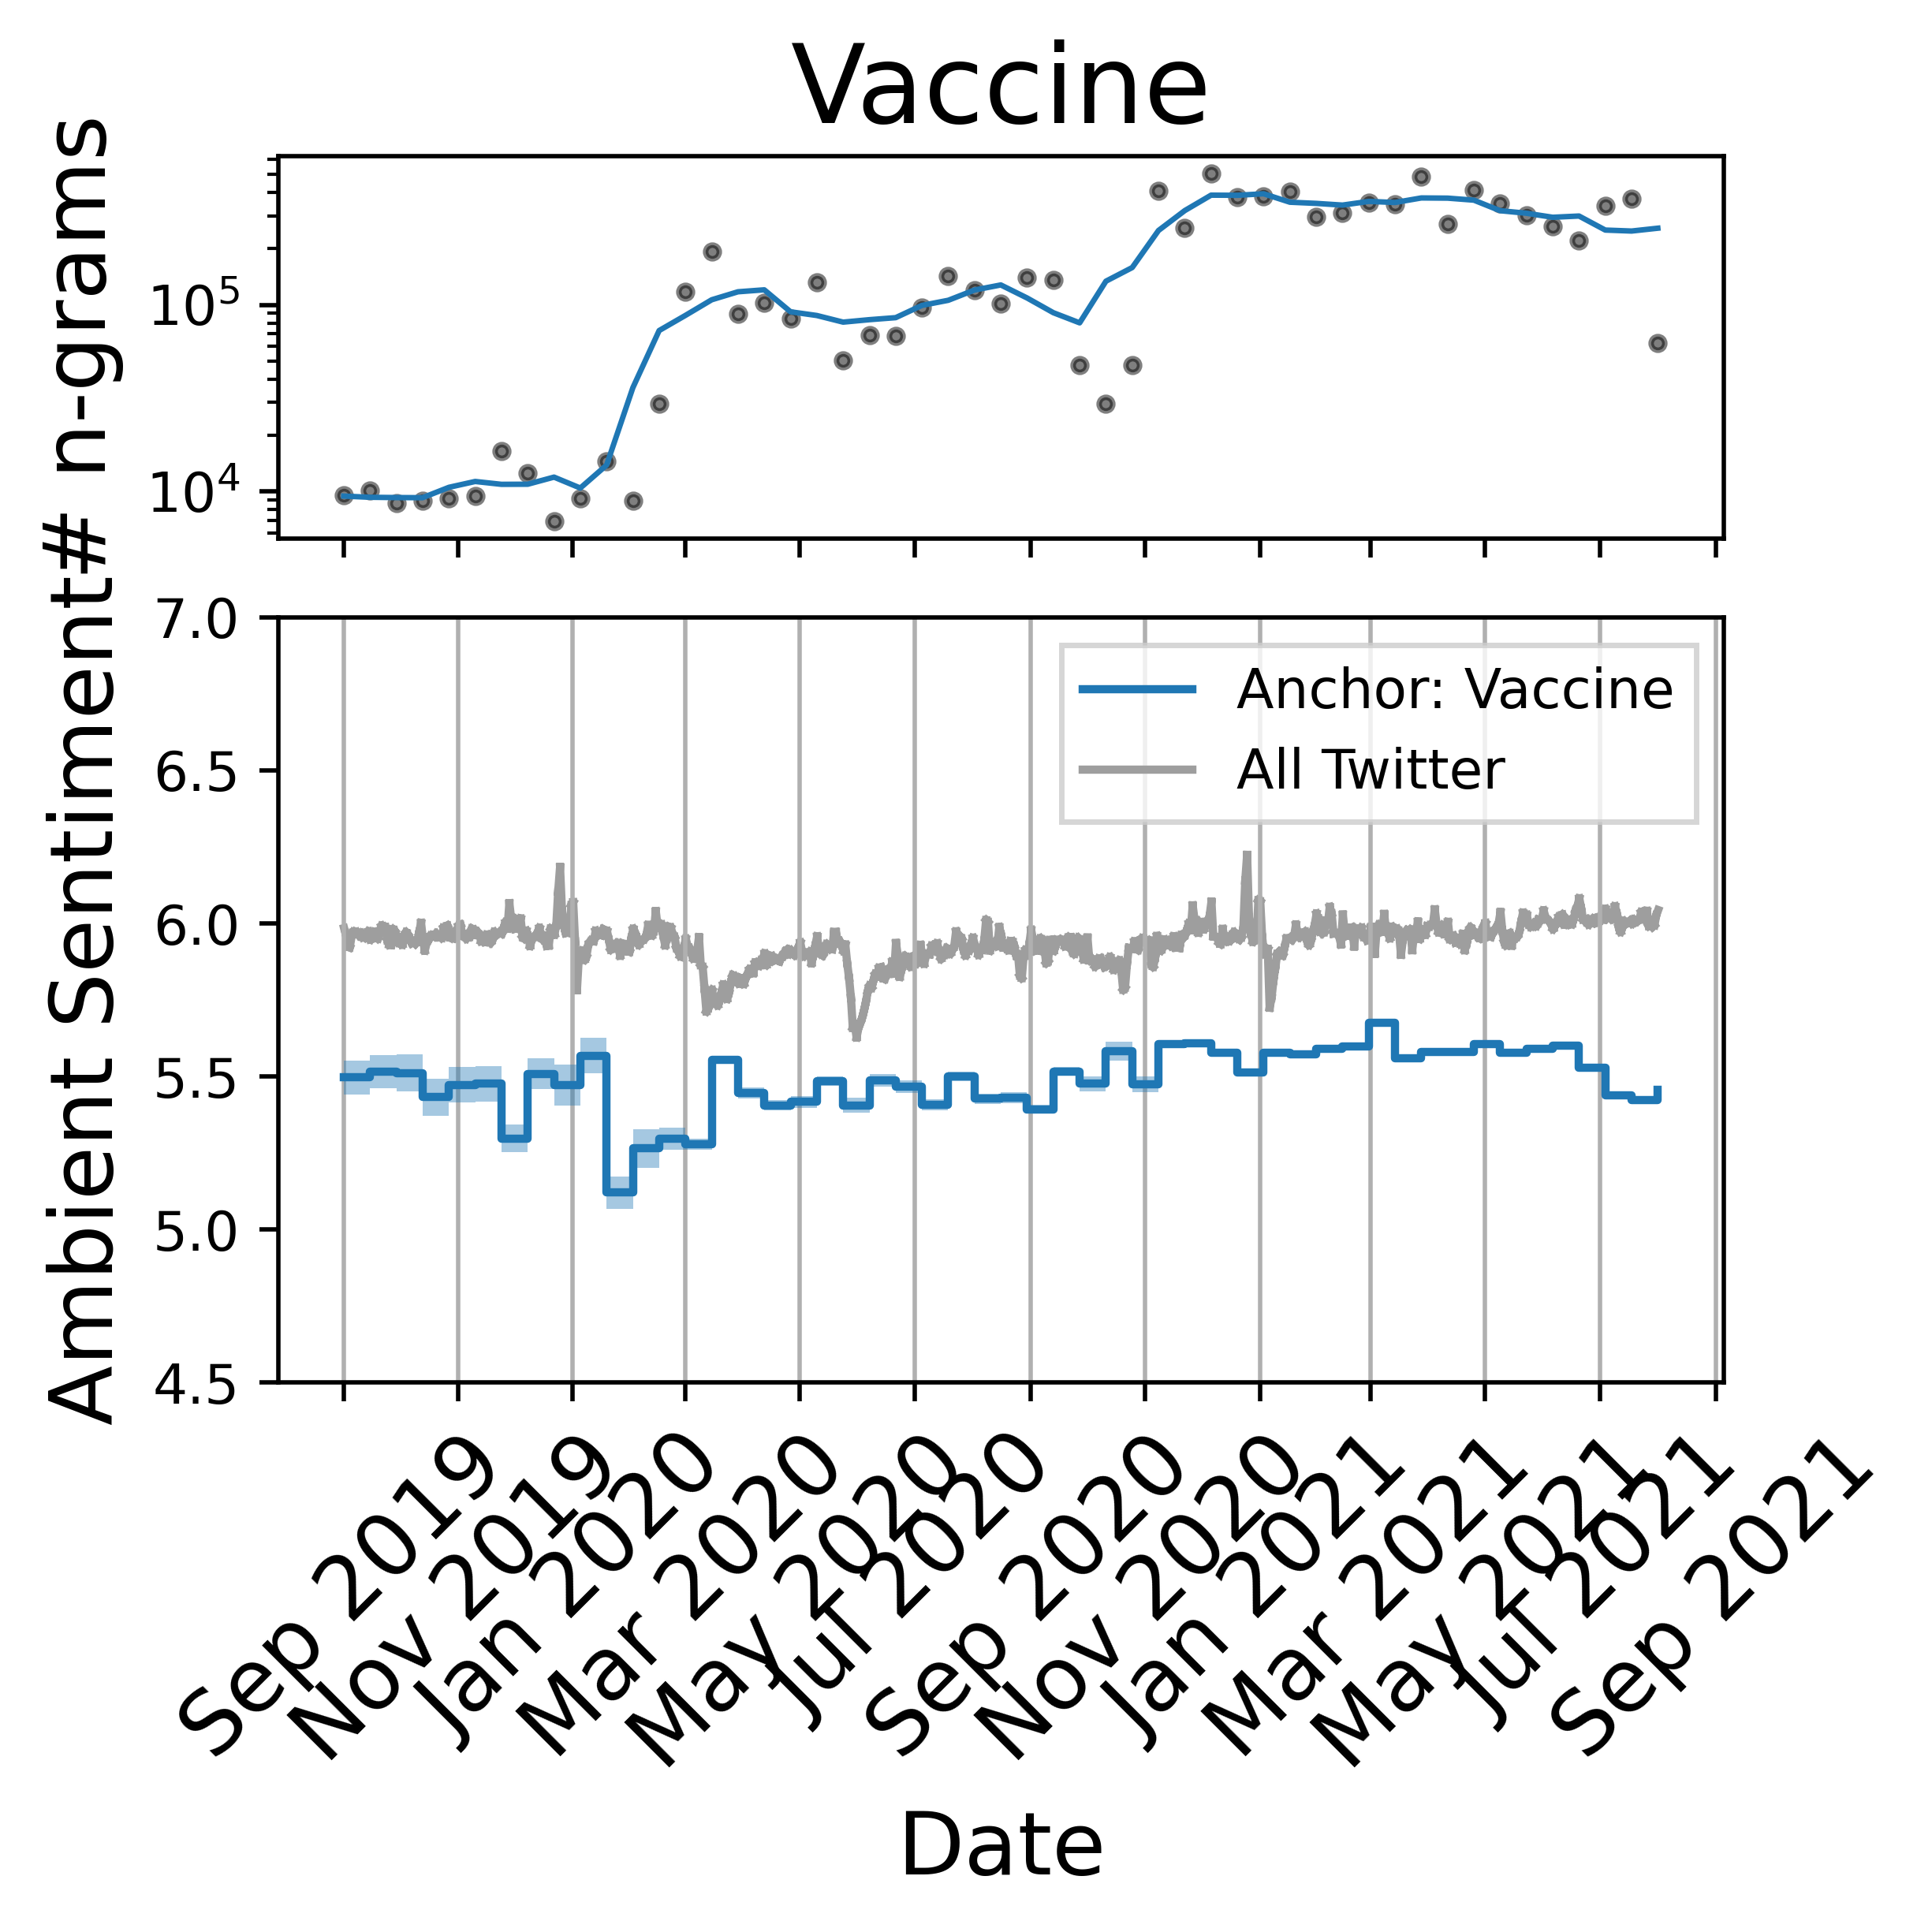

In [12]:
counters.plot_sentiment_timeseries(unsafe=True);

# Sentiment Shifts

There are many possible combinations of sentiment shifts we might be interested in plotting. Only some are already implemented as class methods.

Thanks to Ryan Gallagher for writing the underlying shifterator package.

### Compare two dates

Technically, we're comparing whatever two date ranges we've aggregated to. But given the timestamps for two counters, plot the sentiment shift between them.

/home/michael/anaconda3/envs/tweet_query/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


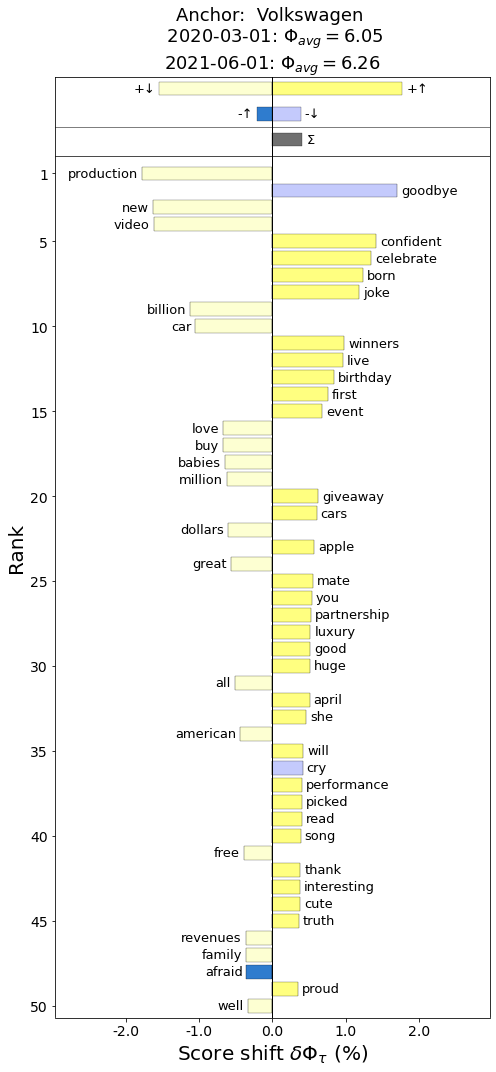

In [42]:
date1 = datetime.datetime(2020, 3 ,1)
date2 = datetime.datetime(2021, 6, 1)
counters.plot_sentiment_shift_dates(date1, date2)

### Sentiment Changepoint

Here we choose a date to split the data at, and collapse all the n-gram data before into a counter and to all the data after.

/home/michael/anaconda3/envs/tweet_query/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


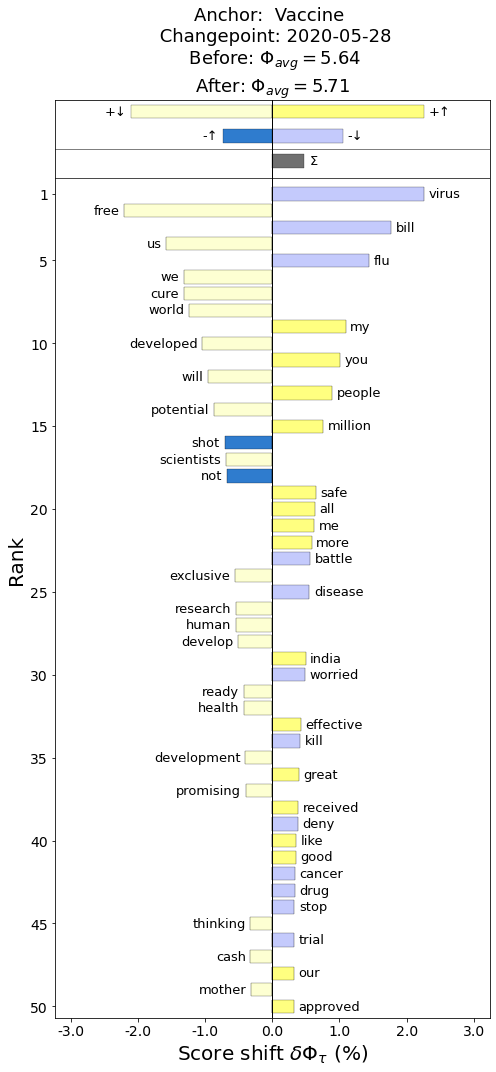

In [16]:
changepoint = datetime.datetime(2020, 5, 28)
counters.plot_sentiment_shift_changepoint(changepoint)

### Sentiment Shift vs Collapsed
How is the sentiment of a given counter is different than the whole distribution?

/home/michael/anaconda3/envs/tweet_query/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


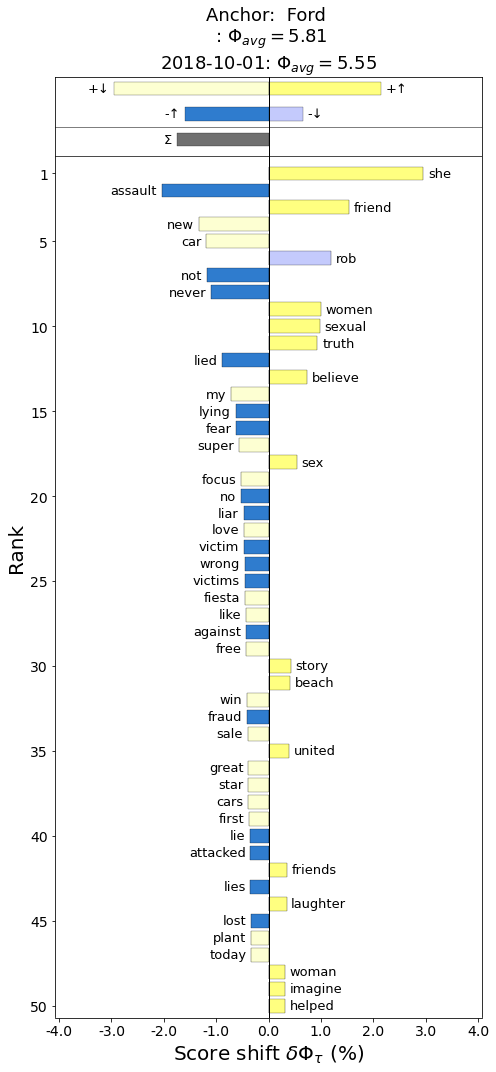

In [50]:
date_i = datetime.datetime(2018,10,1)
counters.plot_sentiment_shift_vs_collapsed(date_i)

# Sentiment Ridge Plot

Somewhat disappointing... 

Sentiment distribution is always dominated by neutral words, so even massive shifts, like for "Orlando" don't look dramatic. But, this is why we use the (4,6) lens to measure sentiment scores.

In [18]:
start_date = datetime.datetime(2016, 4, 1)
end_date = datetime.datetime(2016, 7, 30)
freq = 'D'
dates = pd.date_range(start_date, end_date, freq=freq)
high_res = False

anchor = 'Orlando'

orlando = tweet_query.counters.Counters(dates,
                                         anchor,
                                         high_res=high_res,
                                         )
orlando.get(save=True)


Loading Orlando from counters db...
Loaded Orlando from counters db in 0.87s


In [19]:
orlando.dates

DatetimeIndex(['2016-04-01 00:00:00+00:00', '2016-04-02 00:00:00+00:00',
               '2016-04-03 00:00:00+00:00', '2016-04-04 00:00:00+00:00',
               '2016-04-05 00:00:00+00:00', '2016-04-06 00:00:00+00:00',
               '2016-04-07 00:00:00+00:00', '2016-04-08 00:00:00+00:00',
               '2016-04-09 00:00:00+00:00', '2016-04-10 00:00:00+00:00',
               ...
               '2016-07-21 00:00:00+00:00', '2016-07-22 00:00:00+00:00',
               '2016-07-23 00:00:00+00:00', '2016-07-24 00:00:00+00:00',
               '2016-07-25 00:00:00+00:00', '2016-07-26 00:00:00+00:00',
               '2016-07-27 00:00:00+00:00', '2016-07-28 00:00:00+00:00',
               '2016-07-29 00:00:00+00:00', '2016-07-30 00:00:00+00:00'],
              dtype='datetime64[ns, tzfile('/usr/share/zoneinfo/UTC')]', length=121, freq=None)

In [20]:
orlando.aggregate('W')

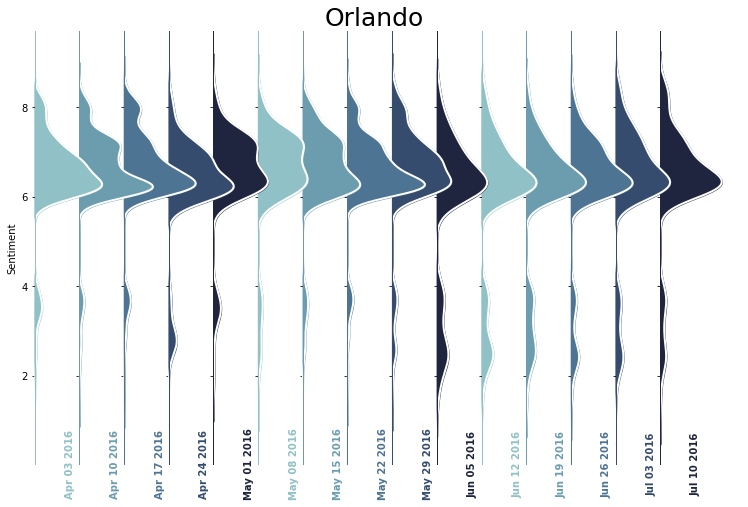

In [21]:
orlando.plot_sentiment_ridge(lens=True, stop_lens=[(4,6)])
plt.rcParams['axes.facecolor']='white'